# Flight Cancellations EDA

Flight Performance data is extracted from the Bueau of Transportation and preprocessed with Apache Beam then stored in BigQuery table before this stage.

- **Local Flight Date:** Date of the flight in the time zone of the origin in YYYY-MM-DD format.
- **Day of Week:** Weekday encoded from 1 to 7, where 1 indicates Sunday.
- **Flight Week:** Week of the year, encoded from 1 to 53.
- **Unique Carrier:** Unique Carrier code
- **Origin airport:** Airport code of the departure
- **Destination airport:** Airport code of the arrival
- **Cancelled:** Indicates whether the flight is cancelled.
- **Cancel Code:** Explains cancellation reason if any with one of the following reasons: 
  - A - Carrier Caused: The cause of the cancellation or delay was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).
  - B - Weather:Significant meteorological conditions (actual or forecasted) that, in the judgment of the carrier, delays or prevents the operation of a flight such as tornado, blizzard or hurricane. 
  - C -  National Aviation System: Delays and cancellations attributable to the national aviation system that refer to a broad set of conditions, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control. This type of weather slows the operations of the system but does not prevent flying. Delays or cancellations coded "NAS" are the type of weather delays that could be reduced with corrective action by the airports or the Federal Aviation Administration.
  - D - Security: Delays or cancellations caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
- **Distance Miles:** Distance from origin to destination airport.
- **Departure and arrival airport Latitude, Longitude:** Added during preprocessing.


## Big Query Auth and imports

In [1]:
%env GOOGLE_APPLICATION_CREDENTIALS=credentials.json
%load_ext google.cloud.bigquery

env: GOOGLE_APPLICATION_CREDENTIALS=credentials.json


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import matplotlib
import seaborn as sns
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (15,7)

## Sample

In [3]:
%%bigquery sample
SELECT LOCAL_FLIGHT_DATE,
DAY_OF_WEEK,
FLIGHT_WEEK,
UNIQUE_CARRIER,
ORIGIN, 
DEST, 
CANCELLED, 
CANCEL_CODE, 
DISTANCE_MILES, 
DEP_AIRPORT_LAT, 
DEP_AIRPORT_LON, 
ARR_AIRPORT_LAT, 
ARR_AIRPORT_LON
FROM airlines_raw.flights_processed_final
WHERE RAND() < 0.0001

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4131/4131 [00:00<00:00, 5023.07rows/s]


In [4]:
sample.sample(5)

LOCAL_FLIGHT_DATE DAY_OF_WEEK FLIGHT_WEEK            UNIQUE_CARRIER  \
2753        2016-10-16           7          42    American Airlines Inc.   
3448        2015-07-12           7          28    Southwest Airlines Co.   
3270        2015-12-11           5          49  ExpressJet Airlines Inc.   
2599        2020-10-12           1          41    Southwest Airlines Co.   
1850        2020-01-22           3           3    Southwest Airlines Co.   

     ORIGIN DEST  CANCELLED CANCEL_CODE  DISTANCE_MILES  DEP_AIRPORT_LAT  \
2753    DFW  PHX      False                       868.0        32.896519   
3448    LAX  OAK      False                       337.0        34.053691   
3270    IND  EWR      False                       645.0        39.768333   
2599    HOU  LAX      False                      1390.0        29.758938   
1850    OAK  SNA      False                       371.0        37.804456   

      DEP_AIRPORT_LON  ARR_AIRPORT_LAT  ARR_AIRPORT_LON  
2753       -97.046522        33.448437      -112.074142  
3448      -118.242766        37.804456      -122.271356  
3270       -86.158350        40.735657       -74.172367  
2599       -95.367697        34.053691      -118.242766  
1850      -122.271356        33.749495      -117.873221

## Monthly Cancellations since 2016

In [5]:
%%bigquery by_date
SELECT 
    EXTRACT(YEAR FROM LOCAL_FLIGHT_DATE) AS FLIGHT_YEAR,
    EXTRACT(MONTH FROM LOCAL_FLIGHT_DATE) AS FLIGHT_MONTH,
    COUNT(*) AS MONTHLY_COUNT,
    SUM(IF(CANCELLED, 1, 0)) AS MONTHLY_CANCELLED_COUNT,
    SUM(IF(CANCELLED, 0, 1)) AS MONTHLY_NONCANCELLED_COUNT   
FROM airlines_raw.flights_processed_final
WHERE LOCAL_FLIGHT_DATE >= "2016-01-01"
GROUP BY 1,2
ORDER BY 1,2

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 74.81rows/s]


In [6]:
by_date["FLIGHT_YEAR_MONTH"] = by_date.apply(lambda x: f"{x['FLIGHT_YEAR']}_{x['FLIGHT_MONTH']:02d}", axis=1)
by_date = by_date.drop(["FLIGHT_YEAR", "FLIGHT_MONTH"], axis=1)
by_date.sample(5)

MONTHLY_COUNT  MONTHLY_CANCELLED_COUNT  MONTHLY_NONCANCELLED_COUNT  \
45         636014                     5172                      630842   
3          461630                     4109                      457521   
65         546124                     8850                      537274   
51         313380                   130076                      183304   
39         612023                    14488                      597535   

   FLIGHT_YEAR_MONTH  
45           2019_10  
3            2016_04  
65           2021_06  
51           2020_04  
39           2019_04

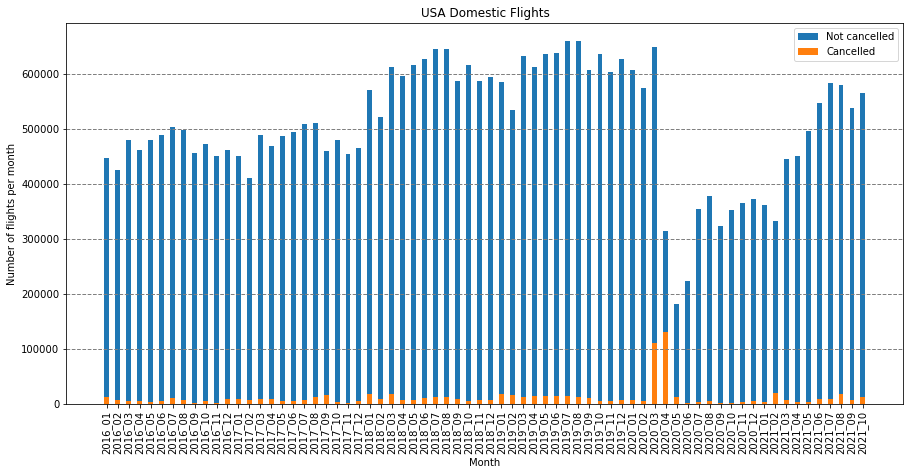

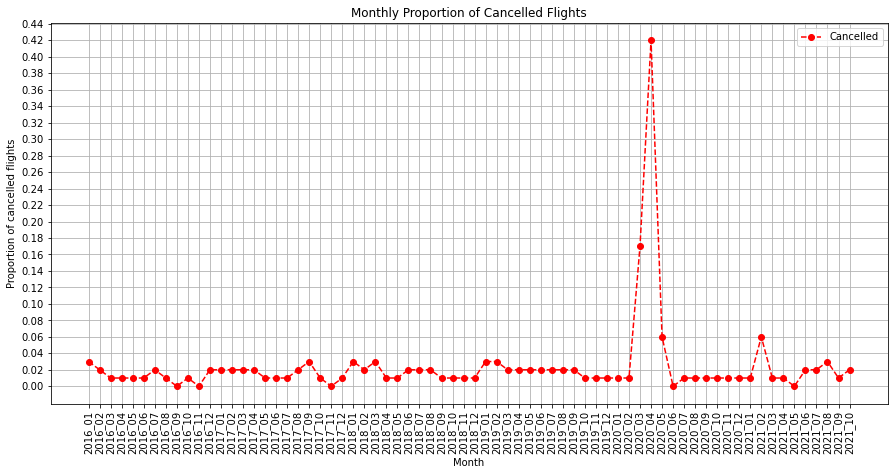

In [7]:
fig, ax = plt.subplots()
ax.bar(by_date["FLIGHT_YEAR_MONTH"], by_date["MONTHLY_NONCANCELLED_COUNT"], 0.45, label="Not cancelled", bottom=by_date["MONTHLY_CANCELLED_COUNT"])
ax.bar(by_date["FLIGHT_YEAR_MONTH"], by_date["MONTHLY_CANCELLED_COUNT"],0.45, label="Cancelled")
ax.tick_params(axis="x", labelsize="medium", labelrotation=90)
ax.set_title("USA Domestic Flights")
ax.set_xlabel("Month")
ax.set_ylabel("Number of flights per month")
ax.grid(color="grey", linestyle="--", axis="y", linewidth=1)
ax.legend();
plt.savefig("cancels1.jpeg", dpi=200)
plt.show()


by_date["PROP"] = by_date.apply(lambda x: round(x["MONTHLY_CANCELLED_COUNT"] / x["MONTHLY_COUNT"], 2), axis=1)
fig, ax = plt.subplots()
ax.plot(by_date["FLIGHT_YEAR_MONTH"], by_date["PROP"],color="red", linestyle="--", marker="o", label="Cancelled")
ax.tick_params(axis="x", labelsize="medium", labelrotation=90)       
ax.set_yticks(np.arange(0.0, 0.45, 0.02))
ax.set_title("Monthly Proportion of Cancelled Flights")
ax.set_xlabel("Month")
ax.set_ylabel("Proportion of cancelled flights")
ax.grid()
ax.legend();

plt.savefig("cancels2.jpeg", dpi=200)

As the number of scheduled flights increases, rate of cancellations remains below 4% until March 2020. When the pandemic hit USA in March, more than 200,000 flights were cancelled in the first 2 months. 

In March 2020, airlines scheduled more than 600,000 flights, where 19% of them were cancelled. 
Although the number of scheduled flights decreased by about 60% in April 2020, 42% of them still got cancelled.
In May 2020, scheduled flights decreased even more down under 200,000 flights, and cancellation rate was down to 6%.

After May 2020, cancellation rate approaches to pre-pandemic level, where number of scheduled flights keeps increading gradually. We see another spike in cancellation rate in February, 2021.

## Reported Reason for Cancellation
Cancellation reason is reported by the airline.

In [8]:
%%bigquery cancel_reason
SELECT 
    A.FLIGHT_YEAR, 
    A.FLIGHT_MONTH, 
    A.CANCEL_CODE, 
    ROUND(CANCEL_CODE_COUNT/TOTAL_CANCELLED_COUNT,4) AS CANCEL_CODE_PRP
FROM(
    SELECT 
        EXTRACT(YEAR from LOCAL_FLIGHT_DATE) as FLIGHT_YEAR, 
        EXTRACT(MONTH from LOCAL_FLIGHT_DATE) as FLIGHT_MONTH, 
        CANCEL_CODE,
        COUNT(*) AS CANCEL_CODE_COUNT
    FROM airlines_raw.flights_processed_final
    WHERE CANCELLED AND LOCAL_FLIGHT_DATE >= "2016-01-01"
    GROUP BY 1,2,3
    ) AS A
    LEFT JOIN 
    (
     SELECT 
        EXTRACT(YEAR from LOCAL_FLIGHT_DATE) as FLIGHT_YEAR, 
        EXTRACT(MONTH from LOCAL_FLIGHT_DATE) as FLIGHT_MONTH, 
        COUNT(*) AS TOTAL_CANCELLED_COUNT 
     FROM airlines_raw.flights_processed_final
     WHERE CANCELLED AND LOCAL_FLIGHT_DATE >= "2016-01-01"
     group by 1,2
    ) as B 
    ON A.FLIGHT_YEAR = B.FLIGHT_YEAR AND A.FLIGHT_MONTH=B.FLIGHT_MONTH
    ORDER BY 1,2

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252/252 [00:00<00:00, 279.37rows/s]


In [9]:
cancel_reason["FLIGHT_YEAR_MONTH"] = cancel_reason.apply(lambda x: f"{x['FLIGHT_YEAR']}_{x['FLIGHT_MONTH']:02d}", axis=1)
cancel_reason = cancel_reason.drop(["FLIGHT_YEAR", "FLIGHT_MONTH"], axis=1)

year_month = cancel_reason["FLIGHT_YEAR_MONTH"].unique()
for y_m in year_month:
    w = cancel_reason.query(f"FLIGHT_YEAR_MONTH == '{y_m}' and CANCEL_CODE=='CARRIER CAUSED'")['CANCEL_CODE_PRP'].iloc[0]
    n = cancel_reason.query(f"FLIGHT_YEAR_MONTH == '{y_m}' and CANCEL_CODE=='NATIONAL AVIATION SYSTEM'")['CANCEL_CODE_PRP'].iloc[0]
    cancel_reason.loc[len(cancel_reason.index)] = ["CARRIER_CAUSED_NAS",w+n,y_m]    

cancel_reason.sort_values(by="FLIGHT_YEAR_MONTH", inplace=True)
cancel_reason.head()

CANCEL_CODE  CANCEL_CODE_PRP FLIGHT_YEAR_MONTH
0                     WEATHER           0.7762           2016_01
2    NATIONAL AVIATION SYSTEM           0.1018           2016_01
252        CARRIER_CAUSED_NAS           0.2238           2016_01
1              CARRIER CAUSED           0.1220           2016_01
3                     WEATHER           0.5542           2016_02

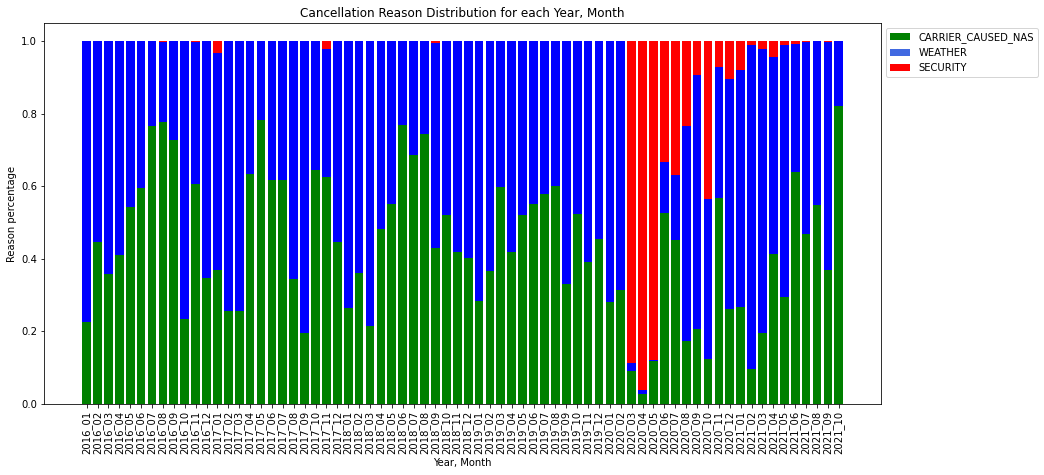

In [10]:
f, ax = plt.subplots()
colors = {"CARRIER_CAUSED_NAS": "green", "WEATHER":"blue","SECURITY": "red"}
cancel_codes = ["CARRIER_CAUSED_NAS", "WEATHER", "SECURITY"]

for y_m in year_month:    
    bottom = 0
    for cancel_code in cancel_codes:        
        mask = (cancel_reason["FLIGHT_YEAR_MONTH"] == y_m) & (cancel_reason["CANCEL_CODE"] == cancel_code)
        if np.sum(mask) > 0:            
            v = cancel_reason[mask]["CANCEL_CODE_PRP"].values[0]            
            ax.bar(y_m, v, label=cancel_code, color=colors[cancel_code], bottom = bottom)
            bottom += v



legend_elements = [Patch(facecolor="green", label="CARRIER_CAUSED_NAS"),
                   Patch(facecolor="royalblue", label="WEATHER"),                   
                   Patch(facecolor="red", label="SECURITY")]

ax.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1,1));
ax.set_title("Cancellation Reason Distribution for each Year, Month")
ax.set_xlabel("Year, Month")
ax.tick_params(axis="x", rotation=90)
plt.savefig("cancel_reason.jpeg", dpi=200)
ax.set_ylabel("Reason percentage");

When the pandemic hit USA domestic travel, because the demand for domestic travel decreased significantly, there were record number of cancellations in March, April and May 2020. These cancellations seem to have been reported as "security" related. The reason for this is explained in BTS documentation in monthly consumer reports. 

BTS reports: "The Coronavirus Disease 2019 (COVID-19) public health emergency has resulted in significant changes in airline schedules and operations, which may have negatively impacted airlines’ on-time performance statistics during this reporting period. On April 17, 2020, the Department issued a notice on Reporting of Causes of Flight Delays and Cancellations Given The Unprecedented Impact of the COVID-19 Public Health Emergency on Air Travel. This notice stated that it would be acceptable for flight delays and cancellations that are directly related to government actions to mitigate the spread of COVID-19 in the United States to be coded in the “security” category for the purposes of categorizing causes of delays and cancellations."

## Construct Train, Validation and Test datasets
We assume cancellation rates behave similarly before and after the pandemic, discarding the 5 first months as anomaly.

In [11]:
%%bigquery
CREATE OR REPLACE VIEW airlines_raw.train AS -- TRAIN
SELECT LOCAL_FLIGHT_DATE, DAY_OF_WEEK, FLIGHT_WEEK, UNIQUE_CARRIER, ORIGIN, DEST, CANCELLED, CANCEL_CODE, DISTANCE_MILES, DEP_AIRPORT_LAT, DEP_AIRPORT_LON, ARR_AIRPORT_LAT, ARR_AIRPORT_LON
FROM airlines_raw.flights_processed_final
WHERE LOCAL_FLIGHT_DATE >= "2018-01-01" AND LOCAL_FLIGHT_DATE < "2020-03-01";

CREATE OR REPLACE VIEW airlines_raw.valid AS -- VALIDATION
SELECT LOCAL_FLIGHT_DATE, DAY_OF_WEEK, FLIGHT_WEEK, UNIQUE_CARRIER, ORIGIN, DEST, CANCELLED, CANCEL_CODE, DISTANCE_MILES, DEP_AIRPORT_LAT, DEP_AIRPORT_LON, ARR_AIRPORT_LAT, ARR_AIRPORT_LON
FROM airlines_raw.flights_processed_final
WHERE LOCAL_FLIGHT_DATE >= "2020-07-01" AND LOCAL_FLIGHT_DATE < "2021-07-01";

CREATE OR REPLACE VIEW airlines_raw.test AS -- TEST
SELECT LOCAL_FLIGHT_DATE, DAY_OF_WEEK, FLIGHT_WEEK, UNIQUE_CARRIER, ORIGIN, DEST, CANCELLED, CANCEL_CODE, DISTANCE_MILES, DEP_AIRPORT_LAT, DEP_AIRPORT_LON, ARR_AIRPORT_LAT, ARR_AIRPORT_LON
FROM airlines_raw.flights_processed_final
WHERE LOCAL_FLIGHT_DATE >= "2021-07-01";

CREATE OR REPLACE VIEW airlines_raw.pandemic AS -- PANDEMIC/ANOMALY
SELECT LOCAL_FLIGHT_DATE, DAY_OF_WEEK, FLIGHT_WEEK, UNIQUE_CARRIER, ORIGIN, DEST, CANCELLED, CANCEL_CODE, DISTANCE_MILES, DEP_AIRPORT_LAT, DEP_AIRPORT_LON, ARR_AIRPORT_LAT, ARR_AIRPORT_LON
FROM airlines_raw.flights_processed_final
WHERE LOCAL_FLIGHT_DATE >= "2020-03-01" AND LOCAL_FLIGHT_DATE < "2020-07-01";



Query complete after 0.00s: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1129.93query/s]


Empty DataFrame
Columns: []
Index: []

## Airlines
- Each airline's total flight count and respective cancellation rate

In [12]:
%%bigquery airlines_cancel
SELECT A.YEAR, A.UNIQUE_CARRIER, A.FLIGHT_COUNT, CANCELLED_FLIGHT_COUNT
FROM
(
SELECT EXTRACT(YEAR FROM LOCAL_FLIGHT_DATE)AS YEAR, UNIQUE_CARRIER, COUNT(*) AS FLIGHT_COUNT
FROM airlines_raw.train
GROUP BY 1,2
) AS A
LEFT JOIN 
(
SELECT EXTRACT(YEAR FROM LOCAL_FLIGHT_DATE) AS YEAR, UNIQUE_CARRIER, COUNT(*) AS CANCELLED_FLIGHT_COUNT
FROM airlines_raw.train
WHERE CANCELLED 
GROUP BY 1,2) AS B
ON A.YEAR=B.YEAR AND A.UNIQUE_CARRIER=B.UNIQUE_CARRIER
ORDER BY 1,2

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 54.85rows/s]


In [13]:
airlines_cancel.head()

YEAR          UNIQUE_CARRIER  FLIGHT_COUNT  CANCELLED_FLIGHT_COUNT
0  2018    Alaska Airlines Inc.        245761                    2207
1  2018           Allegiant Air         96221                     769
2  2018  American Airlines Inc.        916818                   14945
3  2018    Delta Air Lines Inc.        949283                    3528
4  2018       Endeavor Air Inc.        245917                    6355

In [14]:
total = airlines_cancel.groupby("YEAR").agg(TOTAL_FLIGHT_COUNT=("FLIGHT_COUNT", "sum")).reset_index()

airlines_cancel = airlines_cancel.merge(total, on="YEAR", how="left")
airlines_cancel["FLIGHT_PRCNT"] = airlines_cancel.apply(lambda x: round(x["FLIGHT_COUNT"]/ x["TOTAL_FLIGHT_COUNT"], 3)*100, axis=1)
airlines_cancel["CANCEL_PRCNT"] = airlines_cancel.apply(lambda x: round(x["CANCELLED_FLIGHT_COUNT"]/ x["FLIGHT_COUNT"], 3)*100, axis=1)
airlines_cancel["CANCEL_PRCNT_ALL"] = airlines_cancel.apply(lambda x: x["CANCELLED_FLIGHT_COUNT"]/ x["TOTAL_FLIGHT_COUNT"]*100, axis=1)
airlines_cancel.sort_values(by=["YEAR", "UNIQUE_CARRIER"], inplace=True)
airlines_cancel.head()

YEAR          UNIQUE_CARRIER  FLIGHT_COUNT  CANCELLED_FLIGHT_COUNT  \
0  2018    Alaska Airlines Inc.        245761                    2207   
1  2018           Allegiant Air         96221                     769   
2  2018  American Airlines Inc.        916818                   14945   
3  2018    Delta Air Lines Inc.        949283                    3528   
4  2018       Endeavor Air Inc.        245917                    6355   

   TOTAL_FLIGHT_COUNT  FLIGHT_PRCNT  CANCEL_PRCNT  CANCEL_PRCNT_ALL  
0             7213431           3.4           0.9          0.030596  
1             7213431           1.3           0.8          0.010661  
2             7213431          12.7           1.6          0.207183  
3             7213431          13.2           0.4          0.048909  
4             7213431           3.4           2.6          0.088100

In [15]:
airlines_cancel.groupby(["YEAR"]).agg(yearly_cancel=("CANCEL_PRCNT_ALL", "sum"))

yearly_cancel
YEAR               
2018       1.616166
2019       1.816111
2020       1.020893

In [16]:
airlines_cancel[airlines_cancel.isnull().any(axis=1)]

Empty DataFrame
Columns: [YEAR, UNIQUE_CARRIER, FLIGHT_COUNT, CANCELLED_FLIGHT_COUNT, TOTAL_FLIGHT_COUNT, FLIGHT_PRCNT, CANCEL_PRCNT, CANCEL_PRCNT_ALL]
Index: []

## Number of Flights by Airlines until March 2020

In [17]:
import altair as alt
chart_a = alt.Chart(airlines_cancel).mark_bar().encode(
    alt.X("YEAR:O", title=None),
    alt.Y("FLIGHT_PRCNT:Q", title="Percent of Flights"),
    alt.Color("YEAR:N",legend=alt.Legend(title="year"), scale=alt.Scale(scheme='dark2')),
    alt.Facet("UNIQUE_CARRIER", columns=18, title=None))

chart_b = alt.Chart(airlines_cancel).mark_bar().encode(
    alt.X("YEAR:O", title=None),
    alt.Y("CANCEL_PRCNT:Q", title="Airline Cancellation Percent"),
    alt.Color("YEAR:N",legend=alt.Legend(title="year"), scale=alt.Scale(scheme='dark2')),
    alt.Facet("UNIQUE_CARRIER", columns=18, title=None))

chart = chart_a & chart_b.properties(data=airlines_cancel.sample(airlines_cancel.shape[0]))
chart = chart.properties(title="Comparison of Airlines before March 2020")
chart.configure_title(align="center")

chart


alt.VConcatChart(...)

At first look, one might think that Southwest Airlines have the biggest market share, as it owns 18% of scheduled flights, where as Delta airlines have about 13% of market share. But,
Southwest Airlines cancellation rates 3x higher than Delta's. Small market share doesn't necessarily imply small cancel rates, either. For example, we see a big difference in cancellations between JetBlue and PSA Airlines. 

There is no data for Virgin America Inc. for 2019 and 2020, as it was acquired by Alaska Airlines in 2018.

## Airports

In [18]:
%%bigquery airports
SELECT DISTINCT ORIGIN AS AIRPORT, DEP_AIRPORT_LAT AS AIRPORT_LAT, DEP_AIRPORT_LON AS AIRPORT_LON
FROM airlines_raw.flights_processed_final
WHERE LOCAL_FLIGHT_DATE >= "2018-01-01"
UNION DISTINCT
SELECT DISTINCT DEST AS AIRPORT, ARR_AIRPORT_LAT AS AIRPORT_LAT, ARR_AIRPORT_LON AS AIRPORT_LON
FROM airlines_raw.flights_processed_final
WHERE LOCAL_FLIGHT_DATE >= "2018-01-01"

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 394.33rows/s]


In [19]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AIRPORT      381 non-null    object 
 1   AIRPORT_LAT  381 non-null    float64
 2   AIRPORT_LON  381 non-null    float64
dtypes: float64(2), object(1)
memory usage: 9.1+ KB


In [20]:
airports.sample(3)

AIRPORT  AIRPORT_LAT  AIRPORT_LON
272     GSP    34.938136   -82.227212
30      TPA    27.947760   -82.458444
38      COU    38.946404   -92.348463

In [21]:
%%bigquery origin
SELECT A.ORIGIN, A.FLIGHT_COUNT AS TOTAL_FLIGHT_COUNT, CARRIER_C, CANCELLED_CARRIER_C,  CANCELLED_FLIGHT_COUNT, ROUND((CANCELLED_FLIGHT_COUNT/A.FLIGHT_COUNT)*100,2) AS CANCEL_PRCNT
FROM
(
SELECT ORIGIN, COUNT(*) AS FLIGHT_COUNT, COUNT(DISTINCT UNIQUE_CARRIER) AS CARRIER_C
FROM airlines_raw.train
GROUP BY 1) AS A
LEFT JOIN 
(
SELECT ORIGIN, COUNT(*) AS CANCELLED_FLIGHT_COUNT, COUNT(DISTINCT UNIQUE_CARRIER) AS CANCELLED_CARRIER_C
FROM airlines_raw.train
WHERE CANCELLED
GROUP BY 1) AS B
ON  A.ORIGIN=B.ORIGIN
ORDER BY 1,2

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 390.34rows/s]


In [22]:
%%bigquery dest
SELECT A.DEST, A.FLIGHT_COUNT AS TOTAL_FLIGHT_COUNT, CARRIER_C, CANCELLED_CARRIER_C, CANCELLED_FLIGHT_COUNT, ROUND((CANCELLED_FLIGHT_COUNT/A.FLIGHT_COUNT)*100,2) AS CANCEL_PRCNT
FROM
(
SELECT DEST, COUNT(*) AS FLIGHT_COUNT,COUNT(DISTINCT UNIQUE_CARRIER) AS CARRIER_C
FROM airlines_raw.train
GROUP BY 1) AS A
LEFT JOIN 
(
SELECT DEST, COUNT(*) AS CANCELLED_FLIGHT_COUNT,COUNT(DISTINCT UNIQUE_CARRIER) AS CANCELLED_CARRIER_C
FROM airlines_raw.train
WHERE CANCELLED
GROUP BY 1) AS B
ON  A.DEST=B.DEST
ORDER BY 1,2

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 405.27rows/s]


In [23]:
display(origin.info())
display(dest.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ORIGIN                  366 non-null    object 
 1   TOTAL_FLIGHT_COUNT      366 non-null    int64  
 2   CARRIER_C               366 non-null    int64  
 3   CANCELLED_CARRIER_C     361 non-null    float64
 4   CANCELLED_FLIGHT_COUNT  361 non-null    float64
 5   CANCEL_PRCNT            361 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 17.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DEST                    366 non-null    object 
 1   TOTAL_FLIGHT_COUNT      366 non-null    int64  
 2   CARRIER_C               366 non-null    int64  
 3   CANCELLED_CARRIER_C     360 non-null    float64
 4   CANCELLED_FLIGHT_COUNT  360 non-null    float64
 5   CANCEL_PRCNT            360 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 17.3+ KB


None

In [24]:
display(origin[origin.isnull().any(axis=1)])
display(dest[dest.isnull().any(axis=1)])

ORIGIN  TOTAL_FLIGHT_COUNT  CARRIER_C  CANCELLED_CARRIER_C  \
93     DDC                  28          1                  NaN   
169    IFP                  45          1                  NaN   
326    SMX                 393          1                  NaN   
360    WYS                 503          1                  NaN   
364    YNG                   2          1                  NaN   

     CANCELLED_FLIGHT_COUNT  CANCEL_PRCNT  
93                      NaN           NaN  
169                     NaN           NaN  
326                     NaN           NaN  
360                     NaN           NaN  
364                     NaN           NaN

DEST  TOTAL_FLIGHT_COUNT  CARRIER_C  CANCELLED_CARRIER_C  \
13   AKN                 124          1                  NaN   
93   DDC                  29          1                  NaN   
169  IFP                  45          1                  NaN   
326  SMX                 393          1                  NaN   
360  WYS                 503          1                  NaN   
364  YNG                   2          1                  NaN   

     CANCELLED_FLIGHT_COUNT  CANCEL_PRCNT  
13                      NaN           NaN  
93                      NaN           NaN  
169                     NaN           NaN  
326                     NaN           NaN  
360                     NaN           NaN  
364                     NaN           NaN

In [25]:
origin = origin.fillna(0)
dest = dest.fillna(0)

In [26]:
airports_all = origin.merge(dest, left_on="ORIGIN", right_on="DEST", how="left", suffixes=["_ORIGIN", "_DEST"])
airports_all = airports_all.drop("DEST", axis=1)
airports_all = airports_all.rename(columns={"ORIGIN": "AIRPORT"})
airports_all.sample(10)

AIRPORT  TOTAL_FLIGHT_COUNT_ORIGIN  CARRIER_C_ORIGIN  \
59      BZN                      14183                10   
116     EWR                     302114                16   
290     RHI                       1650                 1   
307     SCC                       2086                 1   
65      CHA                      18685                 9   
215     MDW                     182452                 5   
114     EVV                       9217                 8   
160     HTS                       1642                 3   
349     TVC                       8812                10   
42      BLV                       2170                 1   

     CANCELLED_CARRIER_C_ORIGIN  CANCELLED_FLIGHT_COUNT_ORIGIN  \
59                          9.0                           91.0   
116                        16.0                         8344.0   
290                         1.0                           28.0   
307                         1.0                           31.0   
65                          8.0                          291.0   
215                         4.0                         5694.0   
114                         8.0                          196.0   
160                         3.0                           47.0   
349                         7.0                          244.0   
42                          1.0                           16.0   

     CANCEL_PRCNT_ORIGIN  TOTAL_FLIGHT_COUNT_DEST  CARRIER_C_DEST  \
59                  0.64                    14187              10   
116                 2.76                   302155              16   
290                 1.70                     1652               1   
307                 1.49                     2086               1   
65                  1.56                    18684               9   
215                 3.12                   182443               5   
114                 2.13                     9214               8   
160                 2.86                     1640               3   
349                 2.77                     8809              10   
42                  0.74                     2167               1   

     CANCELLED_CARRIER_C_DEST  CANCELLED_FLIGHT_COUNT_DEST  CANCEL_PRCNT_DEST  
59                        8.0                         89.0               0.63  
116                      16.0                       8471.0               2.80  
290                       1.0                         27.0               1.63  
307                       1.0                          7.0               0.34  
65                        8.0                        301.0               1.61  
215                       4.0                       5734.0               3.14  
114                       8.0                        191.0               2.07  
160                       3.0                         36.0               2.20  
349                       7.0                        226.0               2.57  
42                        1.0                         10.0               0.46

In [27]:
all_airports = airports_all["AIRPORT"].unique()
print(f"There are {len(all_airports)} airports in USA")

There are 366 airports in USA


In [28]:
lo,hi = np.percentile(airports_all["TOTAL_FLIGHT_COUNT_ORIGIN"], [1,99])
airports_all[airports_all["TOTAL_FLIGHT_COUNT_ORIGIN"] < lo]

AIRPORT  TOTAL_FLIGHT_COUNT_ORIGIN  CARRIER_C_ORIGIN  \
93      DDC                         28                 1   
169     IFP                         45                 1   
317     SHR                         90                 1   
364     YNG                          2                 1   

     CANCELLED_CARRIER_C_ORIGIN  CANCELLED_FLIGHT_COUNT_ORIGIN  \
93                          0.0                            0.0   
169                         0.0                            0.0   
317                         1.0                            1.0   
364                         0.0                            0.0   

     CANCEL_PRCNT_ORIGIN  TOTAL_FLIGHT_COUNT_DEST  CARRIER_C_DEST  \
93                  0.00                       29               1   
169                 0.00                       45               1   
317                 1.11                       91               1   
364                 0.00                        2               1   

     CANCELLED_CARRIER_C_DEST  CANCELLED_FLIGHT_COUNT_DEST  CANCEL_PRCNT_DEST  
93                        0.0                          0.0                0.0  
169                       0.0                          0.0                0.0  
317                       1.0                          3.0                3.3  
364                       0.0                          0.0                0.0

Some airports have very limited traffic. There is only 1 carrier that flies from/to these airports. For example, YNG is a regional airport, and only Allegiant flies to/from there. 

In [29]:
small_airports = airports_all["CARRIER_C_ORIGIN"] < 2
print(f"Airports with limited traffic  = {small_airports.sum()}")

Airports with limited traffic  = 112


In [30]:
airports_all = airports_all.merge(airports, on="AIRPORT", how="left")
airports_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AIRPORT                        366 non-null    object 
 1   TOTAL_FLIGHT_COUNT_ORIGIN      366 non-null    int64  
 2   CARRIER_C_ORIGIN               366 non-null    int64  
 3   CANCELLED_CARRIER_C_ORIGIN     366 non-null    float64
 4   CANCELLED_FLIGHT_COUNT_ORIGIN  366 non-null    float64
 5   CANCEL_PRCNT_ORIGIN            366 non-null    float64
 6   TOTAL_FLIGHT_COUNT_DEST        366 non-null    int64  
 7   CARRIER_C_DEST                 366 non-null    int64  
 8   CANCELLED_CARRIER_C_DEST       366 non-null    float64
 9   CANCELLED_FLIGHT_COUNT_DEST    366 non-null    float64
 10  CANCEL_PRCNT_DEST              366 non-null    float64
 11  AIRPORT_LAT                    366 non-null    float64
 12  AIRPORT_LON                    366 non-null    flo

In [31]:
bar = alt.Chart(airports_all).mark_bar().encode(
    x="AIRPORT:N",
    y="CANCEL_PRCNT_ORIGIN:Q"
)

rule = alt.Chart(airports_all).mark_rule(color='red').encode(
    y='mean(CANCEL_PRCNT_ORIGIN):Q'
)

(bar + rule).properties()

alt.LayerChart(...)

In [32]:
airports_all[["CARRIER_C_ORIGIN", "CANCELLED_FLIGHT_COUNT_ORIGIN"]].corr()

CARRIER_C_ORIGIN  CANCELLED_FLIGHT_COUNT_ORIGIN
CARRIER_C_ORIGIN                       1.000000                       0.522258
CANCELLED_FLIGHT_COUNT_ORIGIN          0.522258                       1.000000

Busier airports have more cancellation rates. 

## Cancellations by Day of Week

In [33]:
%%bigquery day
SELECT A.DAY_OF_WEEK, TOTAL_FLIGHT, CANCELLED_COUNT, ROUND(CANCELLED_COUNT/TOTAL_FLIGHT * 100, 2) AS CANCEL_PRCNT
FROM
(SELECT DAY_OF_WEEK, COUNT(*) AS TOTAL_FLIGHT
FROM airlines_raw.train
GROUP BY 1) AS A
LEFT JOIN 
(
SELECT DAY_OF_WEEK, COUNT(*) AS CANCELLED_COUNT
FROM airlines_raw.train
WHERE CANCELLED
GROUP BY 1) AS B
ON A.DAY_OF_WEEK=B.DAY_OF_WEEK
ORDER BY 4

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36rows/s]


In [34]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DAY_OF_WEEK      7 non-null      object 
 1   TOTAL_FLIGHT     7 non-null      int64  
 2   CANCELLED_COUNT  7 non-null      int64  
 3   CANCEL_PRCNT     7 non-null      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 352.0+ bytes


In [35]:
day.sample(2)

DAY_OF_WEEK  TOTAL_FLIGHT  CANCELLED_COUNT  CANCEL_PRCNT
1           7       2236186            34157          1.53
4           2       2267026            39275          1.73

In [36]:
alt.Chart(day, width=600).mark_bar().encode(
    x="DAY_OF_WEEK:N",
    y="CANCEL_PRCNT:Q"
)

alt.Chart(...)

Sunday is the first day of the week. Tuesday has the highest cancellation rate, and Friday has the least. 

## Week

In [37]:
%%bigquery week
SELECT A.FLIGHT_WEEK, TOTAL_FLIGHT, CANCELLED_COUNT, ROUND(CANCELLED_COUNT/TOTAL_FLIGHT*100, 2) AS CANCEL_PRCNT
FROM
(SELECT FLIGHT_WEEK, COUNT(*) AS TOTAL_FLIGHT
FROM airlines_raw.train
GROUP BY 1) AS A
LEFT JOIN 
(
SELECT FLIGHT_WEEK, COUNT(*) AS CANCELLED_COUNT
FROM airlines_raw.train
WHERE CANCELLED
GROUP BY 1) AS B
ON A.FLIGHT_WEEK=B.FLIGHT_WEEK
ORDER BY 4

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 58.54rows/s]


In [38]:
week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FLIGHT_WEEK      53 non-null     object 
 1   TOTAL_FLIGHT     53 non-null     int64  
 2   CANCELLED_COUNT  53 non-null     int64  
 3   CANCEL_PRCNT     53 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.8+ KB


In [39]:
bar = alt.Chart(week, width=800).mark_bar().encode(
    x="FLIGHT_WEEK:N",
    y="CANCEL_PRCNT:Q"
)

rule = alt.Chart(week).mark_rule(color='red').encode(
    y='mean(CANCEL_PRCNT):Q'
)

(bar + rule).properties()

alt.LayerChart(...)

There is a significant variation in cancellation rates throughout the year. First 3 weeks of January have a higher cancellation rate than average.

In [40]:
week["CANCEL_PRCNT"].std()

0.6880405382629563

## Distance

In [41]:
%%bigquery distance
SELECT
    AVG(DISTANCE_MILES) AS AVG_DISTANCE,
    STDDEV(DISTANCE_MILES) AS STD_DISTANCE,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(5)] AS percentile_5,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(10)] AS percentile_10,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(15)] AS percentile_15,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(20)] AS percentile_20,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(25)] AS percentile_25,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(30)] AS percentile_30,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(35)] AS percentile_35,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(40)] AS percentile_40,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(45)] AS percentile_45,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(50)] AS percentile_50,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(55)] AS percentile_55,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(60)] AS percentile_60,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(65)] AS percentile_65,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(70)] AS percentile_70,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(75)] AS percentile_75,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(80)] AS percentile_80,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(85)] AS percentile_85,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(90)] AS percentile_90,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(95)] AS percentile_95,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(100)] AS percentile_100
FROM airlines_raw.train

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06rows/s]


In [42]:
distance

AVG_DISTANCE  STD_DISTANCE  percentile_5  percentile_10  percentile_15  \
0    800.023668    594.563316         166.0          224.0          271.0   

   percentile_20  percentile_25  percentile_30  percentile_35  percentile_40  \
0          323.0          366.0          409.0          460.0          528.0   

   ...  percentile_55  percentile_60  percentile_65  percentile_70  \
0  ...          700.0          783.0          867.0          951.0   

   percentile_75  percentile_80  percentile_85  percentile_90  percentile_95  \
0         1034.0         1145.0         1371.0         1620.0         2165.0   

   percentile_100  
0          5095.0  

[1 rows x 22 columns]

5% of distances are shorter than 168 miles. For example flight distance from Seattle to Portland is 146 miles. Longest distance is 5095 miles, between Honolulu and Boston airports.  

In [43]:
%%bigquery distance_dist
SELECT 
COUNTIF(DISTANCE_MILES <= P_5) AS CP5, 
COUNTIF(DISTANCE_MILES > P_5 AND DISTANCE_MILES <= P_10) AS CP10, 
COUNTIF(DISTANCE_MILES > P_10 AND DISTANCE_MILES <= P_15) AS CP15, 
COUNTIF(DISTANCE_MILES > P_15 AND DISTANCE_MILES <= P_20) AS CP20, 
COUNTIF(DISTANCE_MILES > P_20 AND DISTANCE_MILES <= P_25) AS CP25, 
COUNTIF(DISTANCE_MILES > P_25 AND DISTANCE_MILES <= P_30) AS CP30, 
COUNTIF(DISTANCE_MILES > P_30 AND DISTANCE_MILES <= P_35) AS CP35, 
COUNTIF(DISTANCE_MILES > P_35 AND DISTANCE_MILES <= P_40) AS CP40, 
COUNTIF(DISTANCE_MILES > P_40 AND DISTANCE_MILES <= P_45) AS CP45,
COUNTIF(DISTANCE_MILES > P_45 AND DISTANCE_MILES <= P_50) AS CP50, 
COUNTIF(DISTANCE_MILES > P_50 AND DISTANCE_MILES <= P_55) AS CP55, 
COUNTIF(DISTANCE_MILES > P_55 AND DISTANCE_MILES <= P_60) AS CP60, 
COUNTIF(DISTANCE_MILES > P_60 AND DISTANCE_MILES <= P_65) AS CP65, 
COUNTIF(DISTANCE_MILES > P_65 AND DISTANCE_MILES <= P_70) AS CP70, 
COUNTIF(DISTANCE_MILES > P_70 AND DISTANCE_MILES <= P_75) AS CP75, 
COUNTIF(DISTANCE_MILES > P_75 AND DISTANCE_MILES <= P_80) AS CP80, 
COUNTIF(DISTANCE_MILES > P_80 AND DISTANCE_MILES <= P_85) AS CP85, 
COUNTIF(DISTANCE_MILES > P_85 AND DISTANCE_MILES <= P_90) AS CP90, 
COUNTIF(DISTANCE_MILES > P_90 AND DISTANCE_MILES <= P_95) AS CP95, 
COUNTIF(DISTANCE_MILES > P_95) AS CP100       
FROM(
SELECT
  APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(5)] AS p_5,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(10)] AS p_10,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(15)] AS p_15,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(20)] AS p_20,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(25)] AS p_25,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(30)] AS p_30,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(35)] AS p_35,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(40)] AS p_40,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(45)] AS p_45,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(50)] AS p_50,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(55)] AS p_55,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(60)] AS p_60,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(65)] AS p_65,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(70)] AS p_70,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(75)] AS p_75,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(80)] AS p_80,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(85)] AS p_85,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(90)] AS P_90,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(95)] AS p_95,
    APPROX_QUANTILES(DISTANCE_MILES , 100)[OFFSET(100)] AS p_100
FROM airlines_raw.train) AS A, airlines_raw.train

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07rows/s]


In [44]:
distance_dist

CP5    CP10    CP15    CP20    CP25    CP30    CP35    CP40    CP45  \
0  800229  826033  762100  789630  775186  790563  795934  821697  768797   

     CP50    CP55    CP60    CP65    CP70    CP75    CP80    CP85    CP90  \
0  784519  790002  788935  816470  764696  803806  779909  793633  784513   

     CP95   CP100  
0  794179  786115

In [45]:
distance_dist1 = distance_dist.T.reset_index()
distance_dist1.columns=["Percentile", "Count"]

In [46]:
alt.Chart(distance_dist1, width=800).mark_bar().encode(
    x="Percentile:O",
    y="Count:Q"
)

alt.Chart(...)

Overall, airlines in US, fly short distances as much as they fly longer distances.

In [47]:
distance_dist1["Count"].sum()

15816946

In [48]:
%%bigquery distance
SELECT
    (IF(CANCELLED, "CANCELLED", "NOT CANCELLED")) AS CANCELLED, 
    AVG(DISTANCE_MILES) AS AVG_DISTANCE
FROM `sustained-path-337523.airlines_raw.train`
GROUP BY CANCELLED

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.20rows/s]


In [49]:
distance

CANCELLED  AVG_DISTANCE
0  NOT CANCELLED    802.578155
1      CANCELLED    649.203182

In [50]:
alt.Chart(distance, width=400).mark_bar().encode(
    x="AVG_DISTANCE:Q",
    y="CANCELLED:N"  
)

alt.Chart(...)

Cancelled flights go shorter distances on average.

## Feature Engineering
- Filter out Virgin America
- Store Day of Week, Flight Week, Carrier, Airport cancellation rates to file based on training data in Google Cloud Storage

In [52]:
from google.cloud import storage
import os
import json

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )

with open(os.environ['GOOGLE_APPLICATION_CREDENTIALS'], 'r') as fp:
    credentials = json.load(fp)
    project_id = credentials['project_id']    

bucket = f"{project_id}-mixed"

### Write Train, Validation and Test to GCS

In [53]:
%%bash
PROJECT=$(gcloud config get-value project)
BUCKET=${PROJECT}-mixed

bq --project_id=$PROJECT query --destination_table "airlines_raw.train_final" --replace --nouse_legacy_sql \
"SELECT 
    DAY_OF_WEEK, 
    FLIGHT_WEEK, 
    UNIQUE_CARRIER, 
    ORIGIN, 
    DEST, 
    DISTANCE_MILES,
    IF(CANCELLED, 1, 0) AS CANCELLED    
FROM airlines_raw.flights_processed_final
WHERE 
    LOCAL_FLIGHT_DATE >= '2018-01-01' AND 
    LOCAL_FLIGHT_DATE < '2020-03-01' AND
    UNIQUE_CARRIER != 'Virgin America'"
    
bq --project_id=$PROJECT extract --destination_format=CSV airlines_raw.train_final  gs://${BUCKET}/train.csv

+-------------+-------------+------------------------+--------+------+----------------+-----------+
| DAY_OF_WEEK | FLIGHT_WEEK |     UNIQUE_CARRIER     | ORIGIN | DEST | DISTANCE_MILES | CANCELLED |
+-------------+-------------+------------------------+--------+------+----------------+-----------+
| 7           | 8           | JetBlue Airways        | BOS    | PBI  |         1197.0 |         0 |
| 2           | 1           | Endeavor Air Inc.      | ATL    | TYS  |          152.0 |         0 |
| 3           | 50          | Delta Air Lines Inc.   | ATL    | TYS  |          152.0 |         0 |
| 2           | 28          | American Airlines Inc. | BOS    | LGA  |          184.0 |         1 |
| 3           | 37          | Delta Air Lines Inc.   | BOS    | LGA  |          184.0 |         0 |
| 4           | 24          | American Airlines Inc. | BOS    | LGA  |          184.0 |         0 |
| 1           | 34          | Delta Air Lines Inc.   | ATL    | CAE  |          192.0 |         0 |


Waiting on bqjob_r5254f870305b1b58_0000017f1948d5e3_1 ... (14s) Current status: DONE   
Waiting on bqjob_r5e7259dec6ceb4db_0000017f19491908_1 ... (64s) Current status: DONE   


In [54]:
%%bash
PROJECT=$(gcloud config get-value project)
BUCKET=${PROJECT}-mixed

bq --project_id=$PROJECT query --destination_table "airlines_raw.valid_final" --replace --nouse_legacy_sql \
"SELECT 
    DAY_OF_WEEK, 
    FLIGHT_WEEK, 
    UNIQUE_CARRIER, 
    ORIGIN, 
    DEST, 
    DISTANCE_MILES,
    IF(CANCELLED, 1, 0) AS CANCELLED    
FROM airlines_raw.flights_processed_final
WHERE 
    LOCAL_FLIGHT_DATE >= '2020-07-01' AND 
    LOCAL_FLIGHT_DATE < '2021-07-01' AND
    UNIQUE_CARRIER != 'Virgin America'"
    
bq --project_id=$PROJECT extract --destination_format=CSV airlines_raw.valid_final  gs://${BUCKET}/valid.csv

+-------------+-------------+----------------+--------+------+----------------+-----------+
| DAY_OF_WEEK | FLIGHT_WEEK | UNIQUE_CARRIER | ORIGIN | DEST | DISTANCE_MILES | CANCELLED |
+-------------+-------------+----------------+--------+------+----------------+-----------+
| 6           | 0           | Envoy Air      | DFW    | MSY  |          447.0 |         0 |
| 5           | 0           | Envoy Air      | CMI    | DFW  |          692.0 |         1 |
| 5           | 0           | Envoy Air      | DFW    | MFE  |          469.0 |         0 |
| 6           | 0           | Envoy Air      | DFW    | JAN  |          408.0 |         0 |
| 5           | 0           | Envoy Air      | CVG    | MIA  |          948.0 |         0 |
| 6           | 0           | Envoy Air      | DFW    | VPS  |          641.0 |         0 |
| 5           | 0           | Envoy Air      | DFW    | CRP  |          354.0 |         0 |
| 6           | 0           | Envoy Air      | DFW    | GJT  |          773.0 | 

Waiting on bqjob_r4ccafdd22f62cab3_0000017f194a20d6_1 ... (9s) Current status: DONE   
Waiting on bqjob_r3b8f0a94667fbad8_0000017f194a4f6f_1 ... (14s) Current status: DONE   


In [55]:
%%bash
PROJECT=$(gcloud config get-value project)
BUCKET=${PROJECT}-mixed

bq --project_id=$PROJECT query --destination_table "airlines_raw.test_final" --replace --nouse_legacy_sql \
"SELECT 
    DAY_OF_WEEK, 
    FLIGHT_WEEK, 
    UNIQUE_CARRIER, 
    ORIGIN, 
    DEST, 
    DISTANCE_MILES,
    IF(CANCELLED, 1, 0) AS CANCELLED    
FROM airlines_raw.flights_processed_final
WHERE 
    LOCAL_FLIGHT_DATE >= '2021-07-01'"    
    
bq --project_id=$PROJECT extract --destination_format=CSV airlines_raw.test_final  gs://${BUCKET}/test.csv

+-------------+-------------+----------------+--------+------+----------------+-----------+
| DAY_OF_WEEK | FLIGHT_WEEK | UNIQUE_CARRIER | ORIGIN | DEST | DISTANCE_MILES | CANCELLED |
+-------------+-------------+----------------+--------+------+----------------+-----------+
| 4           | 26          | Envoy Air      | ATL    | ORD  |          606.0 |         0 |
| 6           | 26          | Envoy Air      | BRO    | DFW  |          482.0 |         0 |
| 4           | 26          | Envoy Air      | CLT    | TVC  |          702.0 |         0 |
| 4           | 26          | Envoy Air      | TUL    | ORD  |          585.0 |         0 |
| 4           | 26          | Envoy Air      | OKC    | MIA  |         1222.0 |         0 |
| 6           | 26          | Envoy Air      | ORD    | FWA  |          157.0 |         0 |
| 6           | 26          | Envoy Air      | ORD    | CMH  |          296.0 |         0 |
| 6           | 26          | Envoy Air      | SPI    | DFW  |          630.0 | 

Waiting on bqjob_r6d83ec822e64d849_0000017f194a9326_1 ... (4s) Current status: DONE   
Waiting on bqjob_r327f47feb1eeaa30_0000017f194aade0_1 ... (7s) Current status: DONE   


### Day of week

In [56]:
%%bigquery day_of_week
SELECT A.DAY_OF_WEEK, TOTAL_FLIGHT, CANCELLED_COUNT, ROUND(CANCELLED_COUNT/TOTAL_FLIGHT * 100, 2) AS CANCEL_PRCNT
FROM
(SELECT DAY_OF_WEEK, COUNT(*) AS TOTAL_FLIGHT
FROM airlines_raw.train_final
GROUP BY 1) AS A
LEFT JOIN 
(
SELECT DAY_OF_WEEK, COUNT(*) AS CANCELLED_COUNT
FROM airlines_raw.train_final
WHERE CANCELLED=1
GROUP BY 1) AS B
ON A.DAY_OF_WEEK=B.DAY_OF_WEEK
ORDER BY 4

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47rows/s]


In [57]:
file_name = "day_of_week.csv"
day_of_week.to_csv(file_name, index=False, encoding="utf-8")
upload_blob(bucket, file_name, file_name)

File day_of_week.csv uploaded to day_of_week.csv.


### Week of the year

In [58]:
%%bigquery week
SELECT A.FLIGHT_WEEK, TOTAL_FLIGHT, CANCELLED_COUNT, ROUND(CANCELLED_COUNT/TOTAL_FLIGHT*100, 2) AS CANCEL_PRCNT
FROM
(SELECT FLIGHT_WEEK, COUNT(*) AS TOTAL_FLIGHT
FROM airlines_raw.train_final
GROUP BY 1) AS A
LEFT JOIN 
(
SELECT FLIGHT_WEEK, COUNT(*) AS CANCELLED_COUNT
FROM airlines_raw.train_final
WHERE CANCELLED=1
GROUP BY 1) AS B
ON A.FLIGHT_WEEK=B.FLIGHT_WEEK
ORDER BY 4

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 62.31rows/s]


In [59]:
file_name = "week_of_year.csv"
day_of_week.to_csv(file_name, index=False, encoding="utf-8")
upload_blob(bucket, file_name, file_name)

File week_of_year.csv uploaded to week_of_year.csv.


### Carrier

In [60]:
%%bigquery carrier
SELECT A.UNIQUE_CARRIER, ROUND(CANCELLED_FLIGHT_COUNT/FLIGHT_COUNT,4) AS CANCEL_PRP 
FROM
(
SELECT UNIQUE_CARRIER, COUNT(*) AS FLIGHT_COUNT
FROM airlines_raw.train_final
GROUP BY 1
) AS A
LEFT JOIN 
(
SELECT UNIQUE_CARRIER, COUNT(*) AS CANCELLED_FLIGHT_COUNT
FROM airlines_raw.train_final
WHERE CANCELLED=1
GROUP BY 1) AS B
ON A.UNIQUE_CARRIER=B.UNIQUE_CARRIER
ORDER BY 1

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.93rows/s]


In [61]:
file_name = "carrier.csv"
carrier.to_csv(file_name, index=False, encoding="utf-8")
upload_blob(bucket, file_name, file_name)

File carrier.csv uploaded to carrier.csv.


### Origin Airport

In [62]:
%%bigquery origin
SELECT 
    A.ORIGIN, 
    A.FLIGHT_COUNT,
    IF(CANCELLED_FLIGHT_COUNT IS NULL, 0, CANCELLED_FLIGHT_COUNT) AS CANCELLED_COUNT,
    CARRIER_C,
    IF(CANCELLED_FLIGHT_COUNT IS NULL, 0, ROUND(CANCELLED_FLIGHT_COUNT/A.FLIGHT_COUNT,4)) AS CANCEL_PRP
FROM
(
SELECT ORIGIN, COUNT(*) AS FLIGHT_COUNT, COUNT(DISTINCT UNIQUE_CARRIER) AS CARRIER_C
FROM airlines_raw.train_final
GROUP BY 1) AS A
LEFT JOIN 
(
SELECT ORIGIN, COUNT(*) AS CANCELLED_FLIGHT_COUNT
FROM airlines_raw.train_final
WHERE CANCELLED=1
GROUP BY 1) AS B
ON  A.ORIGIN=B.ORIGIN
ORDER BY 1

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 442.05rows/s]


In [63]:
file_name = "origin.csv"
origin.to_csv(file_name, index=False, encoding="utf-8")
upload_blob(bucket, file_name, file_name)

File origin.csv uploaded to origin.csv.


### Destination

In [64]:
%%bigquery dest
SELECT 
  A.DEST, 
  A.FLIGHT_COUNT,
  IF(CANCELLED_FLIGHT_COUNT IS NULL, 0, CANCELLED_FLIGHT_COUNT) AS CANCELLED_COUNT,  
  CARRIER_C,
  IF(CANCELLED_FLIGHT_COUNT IS NULL, 0, ROUND(CANCELLED_FLIGHT_COUNT/A.FLIGHT_COUNT,4)) AS CANCEL_PRP
FROM
(
SELECT DEST, COUNT(*) AS FLIGHT_COUNT, COUNT(DISTINCT UNIQUE_CARRIER) AS CARRIER_C
FROM airlines_raw.train_final
GROUP BY 1) AS A
LEFT JOIN 
(
SELECT DEST, COUNT(*) AS CANCELLED_FLIGHT_COUNT
FROM airlines_raw.train_final
WHERE CANCELLED=1
GROUP BY 1) AS B
ON  A.DEST=B.DEST
ORDER BY 1

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 456.77rows/s]


In [65]:
file_name = "destination.csv"
dest.to_csv(file_name, index=False, encoding="utf-8")
upload_blob(bucket, file_name, file_name)

File destination.csv uploaded to destination.csv.
